In [35]:
# nacitanie kniznic
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler

In [2]:
# definovanie globalnch premennych
AMPS = {
    "DHO": os.listdir("raw_amplitudes/DHO"),
    "GVT": os.listdir("raw_amplitudes/GVT"),
    "ICV": os.listdir("raw_amplitudes/ICV"),
    "JXN": os.listdir("raw_amplitudes/JXN")
}
TIME_WINDOW_TO_DELETE = 10*60*15 # 15 min !!!!!!
TIME_WINDOW_BEFORE_EQ = 10*60*60*3 # 3 hod
TIME_WINDOW_AFTER_EQ = 0

TIME_WINDOW_BEFORE_EQ_HOUR = TIME_WINDOW_BEFORE_EQ/10/60/60
TIME_WINDOW_AFTER_EQ_HOUR = TIME_WINDOW_AFTER_EQ/10/60/60
TIME_WINDOW_BEFORE_EQ_SECOND = TIME_WINDOW_BEFORE_EQ/10
TIME_WINDOW_AFTER_EQ_SECOND = TIME_WINDOW_AFTER_EQ/10

In [21]:
TIME_WINDOW_BEFORE_EQ

108000

# Vyber zemetraseni

In [3]:
eq_biggest_influence_df = pd.read_csv("eq_biggest_influence_per_hour.csv", index_col=0)
print(len(eq_biggest_influence_df))
eq_biggest_influence_df.head(1)

546


,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime,has_influence_on
0,2016-11-16,22:55:54,42.83,13.11,CENTRAL ITALY,10,ML,2.5,546052,22,55,54.0,2016-11-16 22:55:54,ICV


In [8]:
eq_biggest_influence_df["has_influence_on"].value_counts()

has_influence_on
ICV    476
GVT     25
JXN     23
DHO     22
Name: count, dtype: int64

In [36]:
# pomocne funkcie
def load_amp_for_certain_day(day, trans="ICV"):
    file = [f for f in AMPS.get(trans) if f.split("_")[0] == day]
    try:
        return pd.read_csv(f"amplitudes/{trans}/{file[0]}", index_col=0) 
    except IndexError:
        print(f"{trans} data required for date: {day}")
        return pd.DataFrame()

def is_empty(df):
    return True if df.empty else False

def convert_str_to_datetime(trans_amp_window):
    if "datetime" not in trans_amp_window.columns:
        trans_amp_window["datetime"] = pd.to_datetime(trans_amp_window["date"] + " " + trans_amp_window["time"])
    else:
        trans_amp_window["datetime"] = pd.to_datetime(trans_amp_window["datetime"])

# Vyber casoveho okna amplitudy - pozitivne priklady

In [6]:
# vyber casoveho okna amplitudy podla casu vyskytu zemetrasenia.
# Ak casove okno presahuje do predosleho alebo nasledujuceho dna,
# tak je zvysok amplitudy vybrany z tohto dna

amp_window_positive = []
amp_window_positive_list_df = []

# prechadzam vsetky zemetrasenia
for _, eq in eq_biggest_influence_df.iterrows():
    # print("has_influence_on - " + eq.get("has_influence_on"))
    # print("eq id - " + str(eq.get("eqid")))
    eq_day = datetime.strptime(eq.get("date"), "%Y-%m-%d").date()
    amp_df = load_amp_for_certain_day(str(eq_day), eq.get("has_influence_on"))
    if is_empty(amp_df):
        continue
    
    convert_str_to_datetime(amp_df)
    # vyber indexu zaznamu, ktoreho cas zodpoveda casu zemetrasenia
    eq_time_index = list(amp_df.loc[amp_df.get("time") == eq.get("time")].index)[-1]

    # posun indexu podla toho, ak chceme mat niekolko minutovy predstih pred zemetrasenim
    if TIME_WINDOW_TO_DELETE != 0:
        eq_time_index -= TIME_WINDOW_TO_DELETE
    # print(f"eq datetime - {str(eq_day)}----{str(eq.get('time'))}")
    # print(f"eq index - {str(eq_time_index)}")

    # vyber amplitudy, ak okno presahuje do predosleho dna
    if eq_time_index - TIME_WINDOW_BEFORE_EQ < 0:
        amp_other_day_df = load_amp_for_certain_day(str(eq_day - timedelta(days=1)), eq.get("has_influence_on"))
        if is_empty(amp_other_day_df):
            continue
            
        convert_str_to_datetime(amp_other_day_df)
        if eq_time_index < 0:
            index_diff = TIME_WINDOW_BEFORE_EQ
            time_window_amp = amp_other_day_df[-index_diff:eq_time_index]
        else:
            index_diff = TIME_WINDOW_BEFORE_EQ - eq_time_index       
            amp_other_day_slice_df = amp_other_day_df[-index_diff:]    
            time_window_amp = amp_df[:eq_time_index+TIME_WINDOW_AFTER_EQ].copy()       
            time_window_amp = pd.concat([amp_other_day_slice_df, time_window_amp], ignore_index=True)

    # vyber amplitudy, ak okno presahuje do nasledujuceho dna
    elif eq_time_index + TIME_WINDOW_AFTER_EQ > len(amp_df):
        index_diff = (eq_time_index + TIME_WINDOW_AFTER_EQ) - len(amp_df)
        amp_other_day_df = load_amp_for_certain_day(str(eq_day + timedelta(days=1)), eq.get("has_influence_on"))
        if is_empty(amp_other_day_df):
            continue
        
        convert_str_to_datetime(amp_other_day_df)
        amp_other_day_slice_df = amp_other_day_df[:index_diff]
        
        time_window_amp = amp_df[eq_time_index-TIME_WINDOW_BEFORE_EQ:].copy()
        time_window_amp = pd.concat([amp_other_day_slice_df, time_window_amp], ignore_index=True)
    # vyber amplitudy v danom dni
    else:
        time_window_amp = amp_df[eq_time_index-TIME_WINDOW_BEFORE_EQ:eq_time_index+TIME_WINDOW_AFTER_EQ].copy()
        amp_other_day_slice_df = pd.DataFrame()

    # kontrola, ci mame pozadovanu velkost okna
    if len(time_window_amp) < TIME_WINDOW_BEFORE_EQ + TIME_WINDOW_AFTER_EQ:
        continue

    # ulozenie okna do pola
    time_window_amp.reset_index(drop=True, inplace=True)
    time_window_amp["eqid"] = eq.get("eqid")
    time_window_amp["magnitude"] = eq.get("magnitude")
    time_window_amp["eq_time"] = eq.get("time")
    time_window_amp.sort_values(["date", "time", "second"], ascending=True, inplace=True)
        
    amp_window_positive.append({"A_base": list(time_window_amp["A_base"]), "is_eq": 1})
    amp_window_positive_list_df.append(time_window_amp)

amp_window_positive_df = pd.DataFrame(amp_window_positive)

ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
ICV data required for date: 2016-11-16
GVT data required for date: 2016-10-25
JXN data required for date: 2016-10-25
ICV data required for date: 2016-10-07
ICV data required for date: 2016-10-07
JXN data required for date: 2016-10-07
DHO data required for date: 2016-10-07
GVT data required for date: 2016-10-07
ICV data required for date: 2016-10-07
ICV data required for date: 2016-10-07
GVT data required for date: 2016-10-07
ICV data required for date: 2016-09-30
DHO data required for date: 2016-09-30
GVT data required for date: 2016-09-30
ICV data required for date: 2016-09-30
ICV data required for dat

In [7]:
time_window_amp.head(1)

,hour,minute,second,amplitude,date,time,A_base,dA,dA_abs,A_noise,datetime,eqid,magnitude,eq_time
0,0,0,45.9,42.8005,2016-10-01,00:00:45,43.018623,-0.218123,0.218123,0.444948,2016-10-01 00:00:45,534491,2.5,03:15:40


In [8]:
amp_window_positive_df.head(2)

,A_base,is_eq
0,"[12.304512000000004, 12.380404, 12.387794, 12....",1
1,"[12.570185999999996, 12.630015999999998, 12.68...",1


In [19]:
# pre 35 zemetraseni nie su data o amplitude pre dany den
len(amp_window_positive_df["A_base"][0])

108000

In [20]:
# ulozenie datasetu do .csv
# amp_window_positive_df.to_csv("ML/amp_windows_positive_3h_prediction.csv")

In [14]:
df_with_datetime = [d.reset_index(drop=True) for d in amp_window_positive_list_df if "datetime" in d.columns]

In [15]:
len(df_with_datetime)

511

In [139]:
eq_influence_on_path = pd.read_csv("eq_influence_on_path.csv", index_col=0)
eq_influence_on_path.head(1)

,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime,has_influence_on,dist_from_path
3160,2016-09-30,05:58:38,44.43,21.67,SERBIA,2,ML,2.5,534290,5,58,38.0,2016-09-30 05:58:38,ICV,111


In [156]:
df_sample = eq_influence_on_path.loc[
    (eq_influence_on_path["eqid"].isin(eq_biggest_influence_df["eqid"])) &
    (eq_influence_on_path["magnitude"] > 4)
].sample(5)

In [157]:
df_sample

,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime,has_influence_on,dist_from_path
924,2016-11-03,00:35:01,43.03,13.05,CENTRAL ITALY,8,MW,4.8,542463,0,35,1.0,2016-11-03 00:35:01,ICV,88
262,2016-11-12,14:43:33,42.72,13.21,CENTRAL ITALY,10,MB,4.4,544849,14,43,33.0,2016-11-12 14:43:33,ICV,52
1995,2016-10-27,00:21:32,42.96,13.06,CENTRAL ITALY,10,MB,4.2,539777,0,21,32.0,2016-10-27 00:21:32,ICV,81
1442,2016-10-30,18:21:09,42.79,13.15,CENTRAL ITALY,10,ML,4.2,541212,18,21,9.0,2016-10-30 18:21:09,ICV,61
2022,2016-10-26,21:42:02,42.86,13.13,CENTRAL ITALY,10,MW,4.7,539714,21,42,2.0,2016-10-26 21:42:02,ICV,68


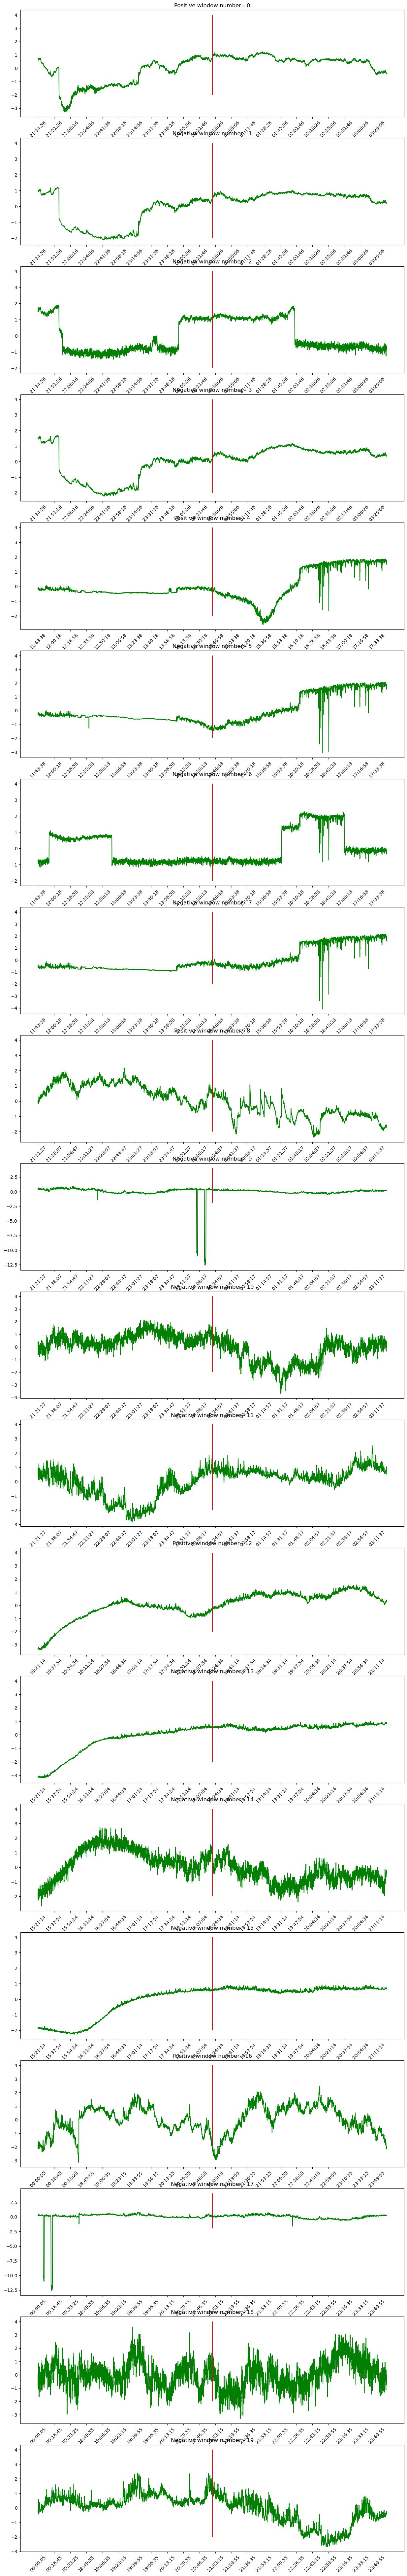

In [160]:
# vzorove vykreslenie pozitivnych ICV prikladov a ku nim negativne priklady z inych vysielacov
fig, ax = plt.subplots(len(df_sample)*4, 1, figsize=(15, 100))
i = 0
for _, eq in df_sample.iterrows():
    eq_day = datetime.strptime(eq.get("date"), "%Y-%m-%d").date()
    amp_df = load_amp_for_certain_day(str(eq_day), eq.get("has_influence_on"))
    if is_empty(amp_df):
        continue
    
    convert_str_to_datetime(amp_df)
    eq_time_index = list(amp_df.loc[amp_df.get("time") == eq.get("time")].index)[-1]
    # print(f"eq datetime - {str(eq_day)}----{str(eq.get('time'))}")
    # print(f"eq index - {str(eq_time_index)}")
    
    if eq_time_index - TIME_WINDOW_BEFORE_EQ < 0:
        index_diff = TIME_WINDOW_BEFORE_EQ - eq_time_index
        amp_other_day_df = load_amp_for_certain_day(str(eq_day - timedelta(days=1)), eq.get("has_influence_on"))
        if is_empty(amp_other_day_df):
            continue
            
        convert_str_to_datetime(amp_other_day_df)
        amp_other_day_slice_df = amp_other_day_df[-index_diff:]
        
        time_window_amp = amp_df[:eq_time_index+TIME_WINDOW_AFTER_EQ].copy()
        time_window_amp = pd.concat([amp_other_day_slice_df, time_window_amp], ignore_index=True)
        
    elif eq_time_index + TIME_WINDOW_AFTER_EQ > len(amp_df):
        index_diff = (eq_time_index + TIME_WINDOW_AFTER_EQ) - len(amp_df)
        amp_other_day_df = load_amp_for_certain_day(str(eq_day + timedelta(days=1)), eq.get("has_influence_on"))
        if is_empty(amp_other_day_df):
            continue
        
        convert_str_to_datetime(amp_other_day_df)
        amp_other_day_slice_df = amp_other_day_df[:index_diff]
        
        time_window_amp = amp_df[eq_time_index-TIME_WINDOW_BEFORE_EQ:].copy()
        time_window_amp = pd.concat([amp_other_day_slice_df, time_window_amp], ignore_index=True)
    else:
        time_window_amp = amp_df[eq_time_index-TIME_WINDOW_BEFORE_EQ:eq_time_index+TIME_WINDOW_AFTER_EQ].copy()
        amp_other_day_slice_df = pd.DataFrame()
    
    if len(time_window_amp) < TIME_WINDOW_BEFORE_EQ + TIME_WINDOW_AFTER_EQ:
        continue
        
    X = np.array(time_window_amp['A_base']) 
    scaler = StandardScaler()
    X_normalized = np.array(scaler.fit_transform(X.reshape(-1, 1)).flatten())
        
    ax[i].plot(time_window_amp.get("time"), X_normalized, color='green')
    ax[i].vlines(time_window_amp.iloc[108000,]["time"],-2,4, color="red")

    tick_interval = 10000
    ax[i].set_xticks(time_window_amp["time"].iloc[::tick_interval])
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].set_title(f"Positive window number - {i}")
    i += 1
    ################################################################################################################
    
    for tr in ["DHO", "JXN", "GVT"]:
        neg_df = load_amp_for_certain_day(str(eq_day), tr)
        if is_empty(neg_df):
            continue

        convert_str_to_datetime(neg_df)
        eq_time_index = list(neg_df.loc[neg_df.get("time") == eq.get("time")].index)[-1]

        if eq_time_index - TIME_WINDOW_BEFORE_EQ < 0:
            index_diff = TIME_WINDOW_BEFORE_EQ - eq_time_index
            amp_other_day_df = load_amp_for_certain_day(str(eq_day - timedelta(days=1)), tr)
            if is_empty(amp_other_day_df):
                continue

            convert_str_to_datetime(amp_other_day_df)
            amp_other_day_slice_df = amp_other_day_df[-index_diff:]

            time_window_amp_neg = neg_df[:eq_time_index+TIME_WINDOW_AFTER_EQ].copy()
            time_window_amp_neg = pd.concat([amp_other_day_slice_df, time_window_amp_neg], ignore_index=True)

        elif eq_time_index + TIME_WINDOW_AFTER_EQ > len(neg_df):
            index_diff = (eq_time_index + TIME_WINDOW_AFTER_EQ) - len(neg_df)
            amp_other_day_df = load_amp_for_certain_day(str(eq_day + timedelta(days=1)), tr)
            if is_empty(amp_other_day_df):
                continue

            convert_str_to_datetime(amp_other_day_df)
            amp_other_day_slice_df = amp_other_day_df[:index_diff]

            time_window_amp_neg = neg_df[eq_time_index-TIME_WINDOW_BEFORE_EQ:].copy()
            time_window_amp_neg = pd.concat([amp_other_day_slice_df, time_window_amp_neg], ignore_index=True)
        else:
            time_window_amp_neg = neg_df[eq_time_index-TIME_WINDOW_BEFORE_EQ:eq_time_index+TIME_WINDOW_AFTER_EQ].copy()
            amp_other_day_slice_df = pd.DataFrame()

        if len(time_window_amp_neg) < TIME_WINDOW_BEFORE_EQ + TIME_WINDOW_AFTER_EQ:
            continue

        X = np.array(time_window_amp_neg['A_base']) 
        scaler = StandardScaler()
        X_normalized = np.array(scaler.fit_transform(X.reshape(-1, 1)).flatten())
    
        ax[i].plot(time_window_amp_neg.get("time"), X_normalized, color='green')
        ax[i].vlines(time_window_amp_neg.iloc[108000,]["time"],-2,4, color="red")

        tick_interval = 10000
        ax[i].set_xticks(time_window_amp_neg["time"].iloc[::tick_interval])
        ax[i].tick_params(axis='x', rotation=45)
        ax[i].set_title(f"Negativa window number - {i}")
        i += 1

# Vyber casoveho okna amplitudy - negativne priklady

In [21]:
# nacitanie zemetraseni do 250km od vzdialenosti vysielac-prijimac
eq_influence_on_path_df = pd.read_csv("eq_influence_on_path.csv", index_col=0)
print(len(eq_influence_on_path_df))
eq_influence_on_path_df.head(1)

1556


,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime,has_influence_on,dist_from_path
3160,2016-09-30,05:58:38,44.43,21.67,SERBIA,2,ML,2.5,534290,5,58,38.0,2016-09-30 05:58:38,ICV,111


array([[<Axes: title={'center': 'magnitude'}>]], dtype=object)

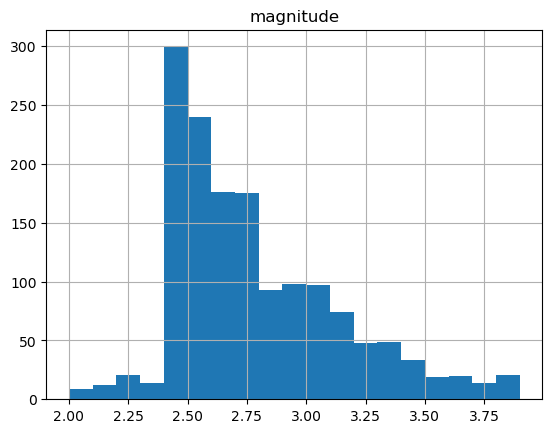

In [22]:
# distribucia hodnot magnitudy
eq_influence_on_path_df.hist(column=["magnitude"], bins=[i for i in np.arange(2, 4, 0.1)])

In [23]:
len(eq_influence_on_path_df)

1556

In [24]:
# vyber zemetraseni z dni s najmensou pocetnostou zemetraseni
daily_counts = eq_influence_on_path_df['date'].value_counts()
valid_dates = daily_counts[daily_counts <= 40].index

eq_df_filtered = eq_influence_on_path_df.loc[
    # (eq_influence_on_path_df["magnitude"] >= 2.5) &
    (eq_influence_on_path_df['date'].isin(valid_dates))
].copy()

In [25]:
eq_df_filtered['date'].value_counts()

date
2016-11-06    37
2016-11-12    35
2016-11-11    34
2016-10-29    33
2016-11-09    31
2016-11-08    30
2016-11-10    27
2016-11-13    23
2016-11-14    22
2016-11-16    18
2016-11-15    16
2016-10-06    12
2016-10-09    10
2016-10-10     9
2016-10-07     9
2016-09-30     9
2016-10-14     8
2016-10-08     8
2016-10-02     7
2016-10-19     7
2016-10-04     6
2016-10-03     6
2016-10-01     5
2016-10-24     4
2016-10-05     4
2016-10-20     4
2016-10-15     3
2016-10-11     2
2016-10-16     2
2016-10-17     2
2016-10-13     2
2016-10-12     2
2016-10-23     2
2016-10-25     2
2016-10-22     2
2016-10-21     1
Name: count, dtype: int64

In [26]:
len(eq_df_filtered)

434

In [27]:
eq_df_filtered.head(1)

,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime,has_influence_on,dist_from_path
3160,2016-09-30,05:58:38,44.43,21.67,SERBIA,2,ML,2.5,534290,5,58,38.0,2016-09-30 05:58:38,ICV,111


In [28]:
# vyber casoveho okna amplitudy podla casu vyskytu zemetrasenia.
# Vyberame okno, ktore nie je v prieniku s oknom okolo casu vyskytu zemetrasenia
# Ak casove okno presahuje do predosleho alebo nasledujuceho dna,
# tak je zvysok amplitudy vybrany z tohto dna

WINDOW_STEP = 10*60*60*3

amp_window_negative = []
amp_window_negative_list_df = []

# prechadzam kazdy den od 1.10.2016 do 16.11.2016
for day in [str(date(2016, 10, 1) + timedelta(days=d)) for d in range(46)]:
    eqs = eq_df_filtered.loc[eq_df_filtered["date"] == day].copy()  
    # prechadzam kazdy vysielac
    for trans in list(AMPS.keys()):
        trans_amp_no_eq_window = load_amp_for_certain_day(day, trans)
        if is_empty(trans_amp_no_eq_window):
            continue

        convert_str_to_datetime(trans_amp_no_eq_window)
        # print(trans + " - amp datetime - " + str(list(trans_amp_no_eq_window["datetime"])[0]))
        i += 1
        if not is_empty(eqs):
            eqs["datetime"] = pd.to_datetime(eqs["datetime"])
            # prechadzam zemetrasenia v danom dni
            for _, eq in eqs.iterrows():
                # vyberem casove okno okolo zemetrasenia
                trans_amp_eq_window = trans_amp_no_eq_window.loc[
                    (trans_amp_no_eq_window["datetime"] > eq.get("datetime") - timedelta(hours=TIME_WINDOW_BEFORE_EQ_HOUR+TIME_WINDOW_TO_DELETE)) & # 3 hod pred zemetrasenim + TIME_WINDOW_TO_DELETE!!!!!!!!!!!!!!!!
                    (trans_amp_no_eq_window["datetime"] < eq.get("datetime") + timedelta(hours=TIME_WINDOW_AFTER_EQ_HOUR)) # 3 hod po zemetraseni
                ]
                # odstranim casove okno okolo zemetrasenia od celeho denneho okna amplitudy
                trans_amp_no_eq_window = trans_amp_no_eq_window.loc[~trans_amp_no_eq_window["time"].isin(trans_amp_eq_window["time"])]
                trans_amp_no_eq_window.reset_index(drop=True, inplace=True)
#############################################################################################################################################################       
        trans_amp_no_eq_window.sort_values(["date", "time", "second"], ascending=True, inplace=True)
        # prechadzam zvysok z denneho okna amplitudy
        for idx in range(0, len(trans_amp_no_eq_window), WINDOW_STEP):
            # vyber okna
            trans_amp_window = trans_amp_no_eq_window.loc[idx:idx+TIME_WINDOW_BEFORE_EQ+TIME_WINDOW_AFTER_EQ-1]
            first_row = trans_amp_window.iloc[0].to_dict()
            last_row = trans_amp_window.iloc[-1].to_dict()
            time_delta = last_row.get("datetime") - first_row.get("datetime")
            # ak je nesulad v case medzi zaznamamy, tak taketo okno sa neberie do uvahy
            if len(trans_amp_window) < TIME_WINDOW_BEFORE_EQ + TIME_WINDOW_AFTER_EQ or time_delta.seconds > TIME_WINDOW_BEFORE_EQ_SECOND + TIME_WINDOW_AFTER_EQ_SECOND + 5:
                continue
            # print(len(trans_amp_window))
            amp_window_negative.append({"A_base": list(trans_amp_window["A_base"]), "is_eq": 0})
            amp_window_negative_list_df.append(trans_amp_window)

amp_window_negative_df = pd.DataFrame(amp_window_negative)

DHO data required for date: 2016-10-07
GVT data required for date: 2016-10-07
ICV data required for date: 2016-10-07
JXN data required for date: 2016-10-07
DHO data required for date: 2016-10-25
GVT data required for date: 2016-10-25
JXN data required for date: 2016-10-25


In [34]:
# ulozenie datasetu
# amp_window_negative_df.to_csv("ML/amp_windows_negative_3h_prediction.csv")

In [29]:
len(amp_window_negative_df)

400

In [30]:
amp_window_negative_df.head()

,A_base,is_eq
0,"[14.028197, 14.002148000000004, 13.94551600000...",0
1,"[6.596995000000004, 6.547003000000005, 6.59699...",0
2,"[37.75805, 37.762775, 37.76397899999999, 37.76...",0
3,"[4.902999, 4.898162, 4.880826, 4.8331189999999...",0
4,"[3.778590000000003, 3.7308410000000034, 3.7183...",0


In [32]:
len(amp_window_negative_list_df)

400

In [40]:
df_with_datetime = [d.reset_index(drop=True) for d in amp_window_negative_list_df if "datetime" in d.columns]

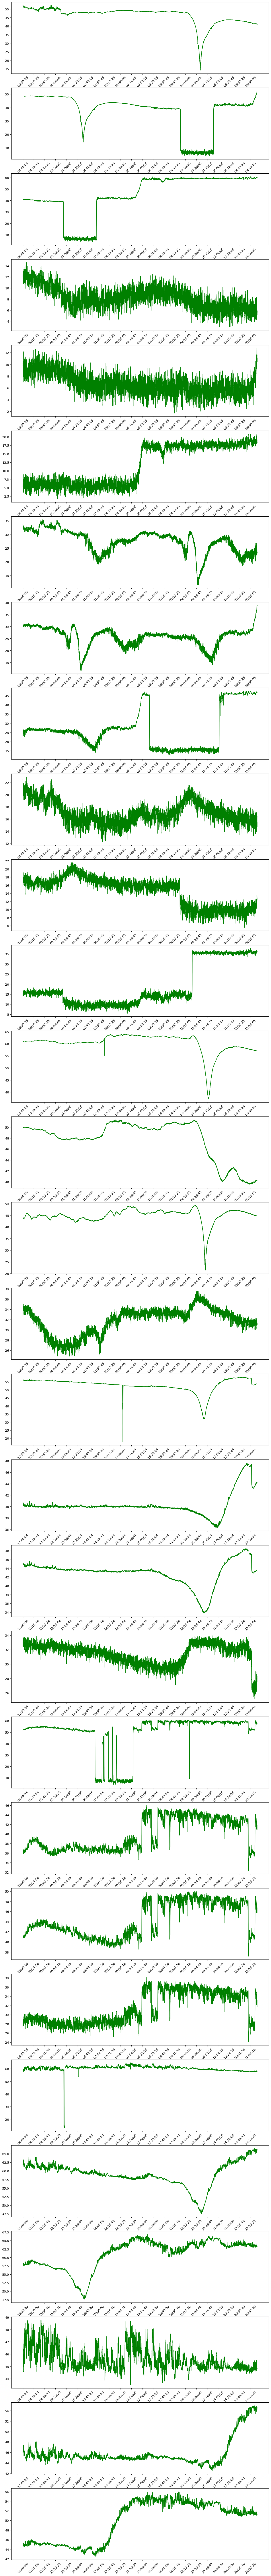

In [42]:
# vzorove vykreslenie negativnych prikladov
fig, ax = plt.subplots(len(df_with_datetime[:30]), 1, figsize=(15, 150))

for idx, df in enumerate(df_with_datetime[:30]):
    X = np.array(df['A_base']) 
    
    ax[idx].plot(df.get("time"), X, color='green')

    tick_interval = 10000
    ax[idx].set_xticks(df["time"].iloc[::tick_interval])
    ax[idx].tick_params(axis='x', rotation=45)

plt.show()